In [1]:
import os
import sys
import pdb
import time
import glob
import functools
import multiprocessing
import numpy as np
import soundfile as sf
import scipy.interpolate
import scipy.io
import scipy.signal
import h5py
import tqdm
import soxr
import importlib

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches
import IPython.display as ipd

sys.path.append('/om2/user/msaddler/python-packages/msutil')
import util_figures
import util_stimuli
import util_misc

import simulator
importlib.reload(simulator)


<module 'simulator' from '/rdma/vast-rdma/vast/mcdermott/msaddler/python-packages/virtual_acoustic_room/simulator.py'>

In [2]:
"""
Run this cell to start the MATLAB engine for Python and import `simulator_matlab`
"""
import matlab.engine
import simulator_matlab
importlib.reload(simulator_matlab)

eng = matlab.engine.start_matlab();
if 'src/' not in eng.path():
    eng.addpath('src/');


In [33]:
"""
Load an example BRIR from Andrew Francl and set simulator parameters to match
"""
# fn = '/scratch2/weka/mcdermott/francl/Room_Simulator_20181115_Rebuild/Expanded_HRIRdist140-5deg_elev_az_room3x3y4z_materials23wall23floor26ciel/15elev_35az_1.40x1.60y2.00z_l.wav'
# room_materials = [23, 23, 23, 23, 23, 26]
# room_dim_xyz = [3, 3, 4]
# head_pos_xyz = [1.4, 1.6, 2.0]
# head_azim = 0
# src_azim = 35
# src_elev = 15
# src_dist = 1.4

fn = '/scratch2/weka/mcdermott/francl/Room_Simulator_20181115_Rebuild/Expanded_HRIRdist140-5deg_elev_az_room5x4y2z_materials1wall15floor16ciel/0elev_45az_3.60x1.40y2.00z_l.wav'
room_materials = [1, 1, 1, 1, 15, 16]
room_dim_xyz = [5, 4, 2]
head_pos_xyz = [3.6, 1.4, 2.0]
head_azim = 0
src_azim = 45
src_elev = 0
src_dist = 1.4

c = 344.5
buffer = 0
sr = 44100
dur = 0.5
use_hrtf_symmetry = True
use_highpass = True
use_jitter = False
use_log_distance = False
hrtf_locs = None
hrtf_firs = None
incorporate_lead_zeros = False

y_l, hrtf_sr = sf.read(fn)
y_r, hrtf_sr = sf.read(fn.replace('_l.wav', '_r.wav'))
brir_francl = np.stack([y_l, y_r], axis=1)
print(f'Loaded francl brir: {fn}: shape={brir_francl.shape} sr={hrtf_sr}')
assert sr == hrtf_sr


Loaded francl brir: /scratch2/weka/mcdermott/francl/Room_Simulator_20181115_Rebuild/Expanded_HRIRdist140-5deg_elev_az_room5x4y2z_materials1wall15floor16ciel/0elev_45az_3.60x1.40y2.00z_l.wav: shape=(22050, 2) sr=44100


In [34]:
"""
Python simulator (run with parameters matched to francl BRIR)
"""
brir_python = simulator.get_brir(
    room_materials=room_materials,
    room_dim_xyz=room_dim_xyz,
    head_pos_xyz=head_pos_xyz,
    head_azim=head_azim,
    src_azim=src_azim,
    src_elev=src_elev,
    src_dist=src_dist,
    buffer=buffer,
    sr=sr,
    dur=dur,
    use_jitter=use_jitter,
    use_hrtf_symmetry=use_hrtf_symmetry,
    incorporate_lead_zeros=incorporate_lead_zeros)


[get_brir] loaded kemar_hrtfs (Gardner & Martin, 1994): (368, 128, 2)
[get_brir] head_pos: [3.6, 1.4, 2.0], src_pos: [4.589949493661167, 2.3899494936611663, 2.0], room_dim: [5, 4, 2]
[get_brir] time elapsed: 35.59306240081787 seconds


In [35]:
"""
MATLAB simulator (via the MATLAB engine for Python)
"""
brir_matlab = simulator_matlab.get_brir(
    room_materials=room_materials,
    room_dim_xyz=room_dim_xyz,
    head_pos_xyz=head_pos_xyz,
    head_azim=head_azim,
    src_azim=src_azim,
    src_elev=src_elev,
    src_dist=src_dist,
    buffer=buffer,
    sr=sr,
    dur=dur,
    use_jitter=use_jitter,
    use_hrtf_symmetry=use_hrtf_symmetry,
    incorporate_lead_zeros=incorporate_lead_zeros,
    verbose=True,
    eng=eng)


[get_brir] head_pos: [3.6, 1.4, 2.0], src_pos: [4.589949493661167, 2.3899494936611663, 2.0], room_dim: [5, 4, 2]
[get_brir] time elapsed: 30.642125129699707 seconds


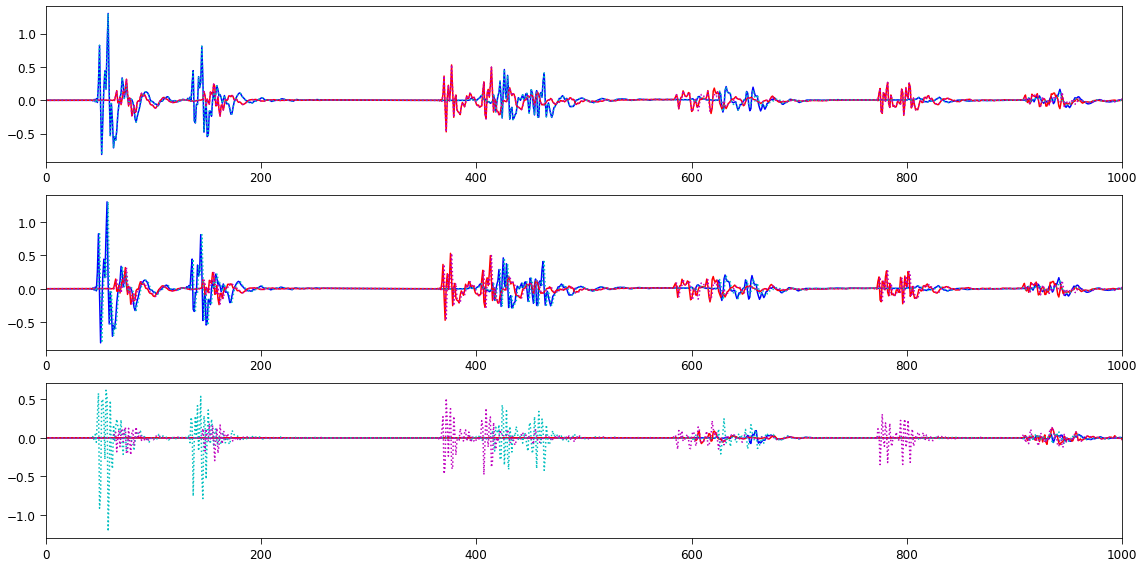

In [36]:
"""
Plot Python, MATLAB, and Francl-generated BRIRs on top of each other
"""
fig, ax_arr = plt.subplots(figsize=(16, 8), nrows=3, ncols=1)
ax_arr[0].plot(brir_python[:, 0], 'b')
ax_arr[0].plot(brir_python[:, 1], 'r')
ax_arr[0].plot(brir_francl[:, 0], 'c', ls=':')
ax_arr[0].plot(brir_francl[:, 1], 'm', ls=':')

ax_arr[1].plot(brir_matlab[:, 0], 'b')
ax_arr[1].plot(brir_matlab[:, 1], 'r')
ax_arr[1].plot(brir_francl[:, 0], 'c', ls=':')
ax_arr[1].plot(brir_francl[:, 1], 'm', ls=':')

ax_arr[2].plot(brir_python[:, 0] - brir_francl[:, 0], 'b')
ax_arr[2].plot(brir_python[:, 1] - brir_francl[:, 1], 'r')
ax_arr[2].plot(brir_matlab[:, 0] - brir_francl[:, 0], 'c', ls=':')
ax_arr[2].plot(brir_matlab[:, 1] - brir_francl[:, 1], 'm', ls=':')

for ax in ax_arr:
    util_figures.format_axes(
        ax,
        xlimits=[0, 1000],
    )
plt.tight_layout()
plt.show()


In [37]:
"""
Example audio (mono source)
"""
fn_audio = '/om2/user/msaddler/spatial_audio_pipeline/assets/human_experiment_v00/background_musdb18hq/000.wav'
y, sr_audio = sf.read(fn_audio)

# Replace example audio clip with noise bursts
y = np.random.randn(*y.shape)
t = np.arange(0, len(y)) / sr_audio
y = (np.sin(2 * np.pi * 2 * t) > 0) * y
fn_audio = 'WHITE NOISE BURSTS'

print(f'Example audio: {fn_audio} (shape={y.shape}, sr={sr_audio})')
ipd.display(ipd.Audio(rate=sr_audio, data=y))


Example audio: WHITE NOISE BURSTS (shape=(132300,), sr=44100)


In [38]:
"""
Example audio convolved with BRIRs
"""
for tag, brir in zip(['francl', 'python', 'matlab'], [brir_francl, brir_python, brir_matlab]):
    y_spatialized = util_stimuli.spatialize_sound(y, brir)
    print(tag, brir.shape, brir.dtype, y_spatialized.shape, y_spatialized.dtype)
    ipd.display(ipd.Audio(rate=sr, data=y_spatialized.T, normalize=True))


francl (22050, 2) float64 (132300, 2) float64


python (22050, 2) float64 (132300, 2) float64


matlab (22050, 2) float64 (132300, 2) float64


In [20]:
"""
DEBUGGING: CLOSELY COMPARE MATLAB AND PYTHON SIMULATORS UNDER DIFFERENT CONDITIONS

NOTES:
- Resulting BRIRs are sometimes offset by one or two samples
    - May be due to an off-by-one indexing error when porting MATLAB to Python
    - May be due to numerical precision differences
"""
room_materials = [1, 1, 1, 1, 15, 16]
room_dim_xyz = [7, 8, 4]
head_pos_xyz = [3.6, 1.4, 2.0]
head_azim = -49
src_azim = 145
src_elev = 20
src_dist = 3.4
buffer = 0.5

c = 344.5
buffer = 0
sr = 44100
dur = 0.5
use_hrtf_symmetry = True
use_highpass = True
use_jitter = False
incorporate_lead_zeros = True
use_log_distance = True
hrtf_locs = None
hrtf_firs = None

importlib.reload(simulator)

np.random.seed(0)
brir_python = simulator.get_brir(
    room_materials=room_materials,
    room_dim_xyz=room_dim_xyz,
    head_pos_xyz=head_pos_xyz,
    head_azim=head_azim,
    src_azim=src_azim,
    src_elev=src_elev,
    src_dist=src_dist,
    buffer=buffer,
    sr=sr,
    c=c,
    dur=dur,
    hrtf_locs=hrtf_locs,
    hrtf_firs=hrtf_firs,
    use_hrtf_symmetry=use_hrtf_symmetry,
    use_log_distance=use_log_distance,
    use_jitter=use_jitter,
    use_highpass=use_highpass,
    incorporate_lead_zeros=incorporate_lead_zeros,
    processes=12,
    strict=True,
    verbose=True)


[get_brir] loaded kemar_hrtfs (Gardner & Martin, 1994): (368, 128, 2)
[get_brir] head_pos: [3.6, 1.4, 2.0], src_pos: [3.2660362729780035, 4.577452613377778, 3.1628684873072737], room_dim: [7, 8, 4]
[get_brir] time elapsed: 8.176598072052002 seconds
[get_brir] incorporated 256 leading zeros


In [19]:
importlib.reload(simulator_matlab)

np.random.seed(0)
brir_matlab = simulator_matlab.get_brir(
    room_materials=room_materials,
    room_dim_xyz=room_dim_xyz,
    head_pos_xyz=head_pos_xyz,
    head_azim=head_azim,
    src_azim=src_azim,
    src_elev=src_elev,
    src_dist=src_dist,
    buffer=buffer,
    sr=sr,
    c=c,
    dur=dur,
    use_hrtf_symmetry=use_hrtf_symmetry,
    use_log_distance=use_log_distance,
    use_jitter=use_jitter,
    use_highpass=use_highpass,
    incorporate_lead_zeros=incorporate_lead_zeros,
    eng=eng)


[get_brir] head_pos: [3.6, 1.4, 2.0], src_pos: [3.2660362729780035, 4.577452613377778, 3.1628684873072737], room_dim: [7, 8, 4]
[get_brir] time elapsed: 7.349673271179199 seconds
[get_brir] incorporated 256 leading zeros


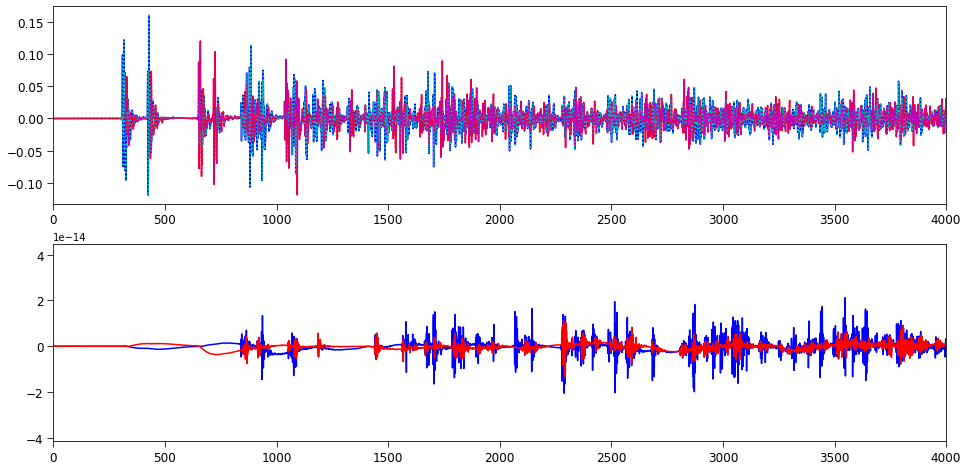

In [25]:
fig, ax_arr = plt.subplots(figsize=(16, 8), nrows=2, ncols=1)

offset_brir_python = brir_python[1:]
offset_brir_matlab = brir_matlab[:-1]

ax_arr[0].plot(offset_brir_python[:, 0], 'b')
ax_arr[0].plot(offset_brir_python[:, 1], 'r')
ax_arr[0].plot(offset_brir_matlab[:, 0], 'c', ls=':')
ax_arr[0].plot(offset_brir_matlab[:, 1], 'm', ls=':')
ax_arr[1].plot(offset_brir_python[:, 0] - offset_brir_matlab[:, 0], 'b')
ax_arr[1].plot(offset_brir_python[:, 1] - offset_brir_matlab[:, 1], 'r')

for ax in ax_arr:
    util_figures.format_axes(
        ax,
        xlimits=[0, 4000],
#         ylimits=[-0.01, 0.01]
    )
plt.show()


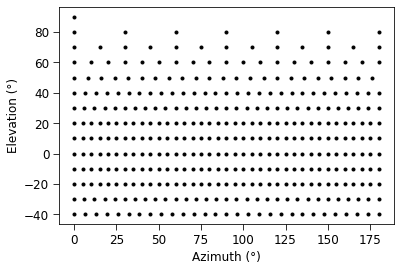

In [28]:
"""
Check kemar_hrtf locations (azimuths and elevations)
"""
hrtf_locs = np.load('kemar_hrtfs/hrtfs.npz')['hrtf_locs']
fig, ax = plt.subplots()
x = hrtf_locs[:, 1]
y = hrtf_locs[:, 2]
ax.plot(x, y, 'k.')
ax = util_figures.format_axes(
    ax,
    str_xlabel='Azimuth (°)',
    str_ylabel='Elevation (°)')
plt.show()


In [ ]:
# """
# PROFILING SCRATCH WORK TO IMPROVE SIMULATOR PERFORMANCE
# """

# import cProfile
# import pstats
# importlib.reload(simulator)

# func_to_profile = lambda : simulator.get_brir(
#     room_materials=[23, 23, 23, 23, 23, 26],
#     room_dim_xyz=[3, 3, 4],
#     head_pos_xyz=[1.4, 1.6, 2.0],
#     head_azim=0,
#     src_azim=35,
#     src_elev=15,
#     src_dist=1.4,
#     sr=44100,
#     dur=0.5,
#     use_jitter=False,
#     use_hrtf_symmetry=True,
#     incorporate_lead_zeros=False)

# cProfile.run('func_to_profile()', 'profiler_stats')

# p = pstats.Stats('profiler_stats')
# p.strip_dirs().sort_stats('cumulative').print_stats()


In [39]:
"""
Quit MATLAB engine
"""
eng.quit()
